In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-2635t913
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-2635t913
  Resolved https://github.com/facebookresearch/detectron2.git to commit 3ff5dd1cff4417af07097064813c9f28d7461d3c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import ColorMode

# other libs (other necessary imports in Colab file to make the list shorter here)

import torch, torchvision
import torchvision.transforms as transforms
from pathlib import Path
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import cv2

[02/08 08:46:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/input/model23000-02/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


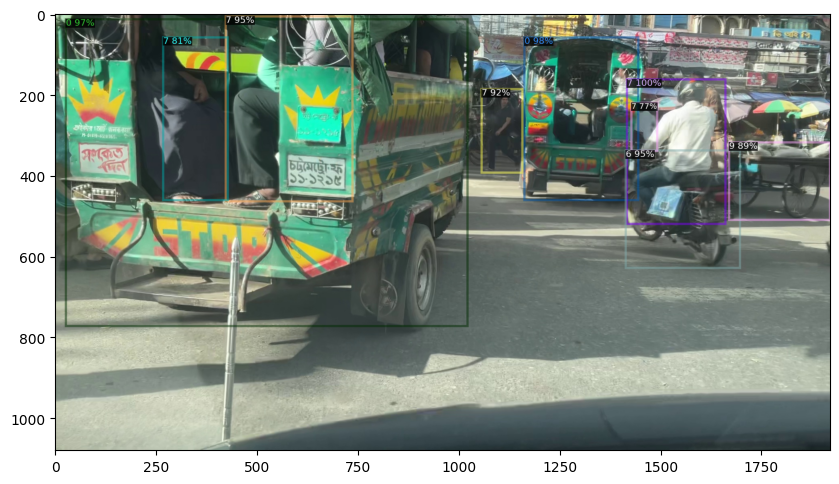

In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = 'cuda' # cuda
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13
cfg.MODEL.WEIGHTS = "model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

im = cv2.imread("/kaggle/input/1st-image-in-test/chittagong_bohoddarhat1_1003.jpg")
outputs = predictor(im)
v = Visualizer(im, scale=1., instance_mode =  ColorMode.IMAGE    )

v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = v.get_image()[:,:,[2,1,0]]
img = Image.fromarray(img)
plt.figure(figsize=(10, 10))
plt.imshow(img)

In [4]:
def get_prediction_string(boxes, scores, classes,height1, width1):
    pred_strs = []
    for i, score in enumerate(scores):
        single_pred_str = ""
        single_pred_str += str(float(classes[i])) + " " + str(float(score)) + " "
        #print(boxes[i])
        x_center , y_center, width,height = boxes[i]
        x1 = ((float(x_center) + float(width))/2)/float(width1)
        y1 = ((float(y_center) + float(height))/2)/float(height1)
        
        width = (-float(x_center) + float(width))/float(width1)
        height = (-float(y_center) + float(height))/float(height1)
        x2=float(x1)-(float(width)/2)
        y2=float(y1)-(float(height)/2)
        #single_pred_str += " ".join(str(float(x)) for x in boxes[i])
        single_pred_str +=  f"{x2} {y2} {width} {height}"
        
        pred_strs.append(single_pred_str)
    ans = ','.join(map(str, pred_strs))
    if len(ans):
        return ans
#     the solution metrics faield in case of a NaN, '' (empty). So, return "0 0 0 0 0 0" for NaN, '' (empty) string
    return "0 0 0 0 0 0"

# get the predcition in id, ImageID, PredictionString_pred foramt ...

def get_prediction_entry(i, filename, boxes, scores, classes,height1, width1):
    return {
        "id": i, # strating from 0 ...
        "ImageID": filename.split('.')[0], # before the extension ...
        "PredictionString_pred": get_prediction_string(boxes, scores, classes,height1, width1)
    }

# Directory path ...
test_directory = "/kaggle/input/dl-enigma-10-sust-cse-carnival-2024/dlenigma1/BadODD/images/test"
#test_directory = "/kaggle/input/image-test"
# Load the model ...
#model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# do the inference ...

def predict_all_files(test_directory):
    predictions = []
    for i,filename in tqdm(enumerate(os.listdir(test_directory))):
        if filename.endswith(".jpg"):
            filepath = os.path.join(test_directory, filename)
            im = cv2.imread(filepath)
            height1, width1, _ = im.shape
            
            #print(im.shape)
            results = predictor(im)
            instances = results["instances"]
            boxes_cpu = instances.pred_boxes.tensor.cpu()
            scores_cpu = instances.scores.cpu()
            classes_cpu = instances.pred_classes.cpu()

                   # Convert CPU tensors to NumPy arrays
            boxes = boxes_cpu.numpy()  # Extract bounding boxes as a numpy array
            scores = scores_cpu.numpy()  # Extract prediction scores as a numpy array
            classes = classes_cpu.numpy()
            prediction = get_prediction_entry(i, filename, boxes, scores, classes,height1, width1)
            predictions.append(prediction)
            #print(predictions[0])
            
#             to csv format ...
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv("submission.csv", index=False)

# call the inference function ...
predict_all_files(test_directory)

1964it [04:21,  7.51it/s]
